# Chapter 3: Getting Started with Neural Networks (DLWP Notes)

**Reuters dataset** - a short of newswires and their topics, published by Reuters in 1986.
* 46 different topics/classes
* Not equally distributed (some topics have more examples than others)
* Each topic has at least 10 examples

In [1]:
import matplotlib.pyplot as plt
import keras
from keras.datasets import reuters

In [4]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000) # only pull the 10k most frequent words across all articles

In [6]:
len(train_data), len(test_data)

(8982, 2246)

In [8]:
train_data[0][:10] # each datapoint is a list of indices in the word_index, which we're about to pull.

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207]

In [29]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # swaps key-val pairs
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

In [28]:
list(word_index)[:4] # dict keys

['mdbl', 'fawc', 'degussa', 'woods']

## Vectorize sequences

In [18]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [21]:
## Vectorize labels (via one-hot-encoding)

from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [24]:
one_hot_train_labels[:1] # each label is a 2D tensor with all zeros, except one 1

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

## Neural Network Architecture for Multi-Class Problems

In the last example (binary classification), we used 2 16-hidden-unit, relu-activated layers and a 1D output.

Now, we have 46 different classes. So a 16-D space may not be enough to separate the data into 46 classes. For that reason, let's use a 64-unit hidden layer. The number of hidden units should be greater than the num dimensions of the output

**The output layer for a multiclass problem should usually be `softmax`, which outputs a 46-dimensional *probability distribution* over the different output classes.** 
* each label will have a probablity associated, the sum of all of them == 1

In [30]:
from keras import models, layers

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # output layer

## Loss Function Selection

**For multiclass problems, use **categorical_crossentropy**. 

**categorical_crossentropy** measures the distances between two probability distributions:

1. Probablity output of the network
2. True distribution of the labels

By minimizing the distance between the two distributions, you train the network to output something as close as possible to the true labels.


In [32]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

## Batch Size

Batch size is the number of samples to be processed simultaneously for the model.

The number of samples should be base-2, and is usually between 8-128.

In [33]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [34]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=512,
validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 33ms/step - loss: 3.0853 - accuracy: 0.4286 - val_loss: 1.6969 - val_accuracy: 0.6380
Epoch 2/20
16/16 [==============================] - 0s 18ms/step - loss: 1.4849 - accuracy: 0.6954 - val_loss: 1.2816 - val_accuracy: 0.7150
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.0715 - accuracy: 0.7671 - val_loss: 1.1212 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 0s 18ms/step - loss: 0.8543 - accuracy: 0.8150 - val_loss: 1.0168 - val_accuracy: 0.7840
Epoch 5/20
16/16 [==============================] - 0s 22ms/step - loss: 0.6654 - accuracy: 0.8650 - val_loss: 0.9412 - val_accuracy: 0.8050
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.5151 - accuracy: 0.8938 - val_loss: 0.9051 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 0s 19ms/step - loss: 0.4167 - accuracy: 0.9133 - val_loss: 0.8709 - val_accuracy: 0.8190
Epoch 8/20
16

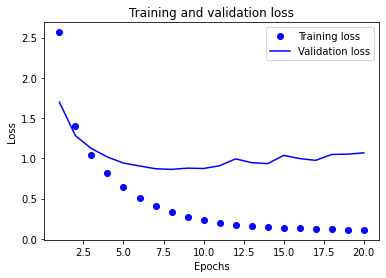

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

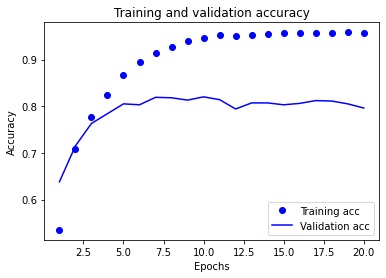

In [39]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Optimizing num. epochs

Using above **Training and Validation *Loss*** plot, we see that the model starts to overfit after ~9 epochs. Let's retrain the model from scratch, using those 9 epochs.

In [53]:
model = keras.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,))) # input layer
model.add(layers.Dense(64, activation='relu')) # hidden layers start here
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 25ms/step - loss: 3.0903 - accuracy: 0.4123 - val_loss: 1.7156 - val_accuracy: 0.6350
Epoch 2/9
16/16 [==============================] - 0s 19ms/step - loss: 1.4970 - accuracy: 0.6891 - val_loss: 1.2929 - val_accuracy: 0.7130
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 1.0775 - accuracy: 0.7713 - val_loss: 1.1204 - val_accuracy: 0.7490
Epoch 4/9
16/16 [==============================] - 0s 18ms/step - loss: 0.8455 - accuracy: 0.8220 - val_loss: 1.0092 - val_accuracy: 0.7710
Epoch 5/9
16/16 [==============================] - 0s 18ms/step - loss: 0.6830 - accuracy: 0.8584 - val_loss: 0.9557 - val_accuracy: 0.7890
Epoch 6/9
16/16 [==============================] - 0s 19ms/step - loss: 0.5301 - accuracy: 0.8919 - val_loss: 0.8993 - val_accuracy: 0.8120
Epoch 7/9
16/16 [==============================] - 0s 19ms/step - loss: 0.4384 - accuracy: 0.9092 - val_loss: 0.8724 - val_accuracy: 0.8200
Epoch 8/9
16/16 [===

In [54]:
results

[0.9606403112411499, 0.7862867116928101]

# Example Takeaways

Here’s what you should take away from this example:


* If you’re trying to classify data points among N classes, your network should end with a Dense layer of size N.


* In a single-label, multiclass classification problem, your network should end with a softmax activation so that it will output a probability distribution over the N output classes.


* Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network and the true distribution of the targets.


* There are two ways to handle labels in multiclass classification:
    1. Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function
    2. Encoding the labels as integers and using the sparse_categorical_crossentropy loss function


* If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small.